Kernel PCA atualizado, vai passar por mais algumas modificações: \\
Deixar alguns parametros como default  \\
Inclusão de outros tipos de resolução de pre-image \\


In [6]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
from scipy.optimize import minimize, Bounds
from sklearn.cluster import KMeans


class KernelPCA:
    def __init__(self, gamma, variance_ratio_threshold, kernel_type, degree, n_clusters):
        """
        Inicializa o Kernel PCA com os parâmetros especificados.

        Parâmetros:
        - gamma: float, parâmetro para o kernel RBF
        - variance_ratio_threshold: float, limiar para a variância explicada acumulada
        - kernel_type: str, tipo de kernel a ser utilizado ('rbf', 'polynomial', 'linear')
        - degree: int, grau para o kernel polinomial
        """
        self.gamma = gamma
        self.variance_ratio_threshold = variance_ratio_threshold
        self.kernel_type = kernel_type
        self.degree = degree
        self.n_clusters = n_clusters
        self.X_fit_ = None
        self.K_ = None
        self.eigvals_ = None
        self.eigvecs_ = None
        self.alphas_ = None
        self.lambdas_ = None

    def fit(self, X):
        """
        Ajusta o modelo Kernel PCA aos dados X.

        Parâmetros:
        - X: ndarray, shape (n_samples, n_features), os dados de entrada
        """
        self.X_fit_ = X

        # Calcula as distâncias euclidianas quadradas entre pares
        sq_dists = pdist(X, 'sqeuclidean')

        # Converte as distâncias entre pares em uma matriz simétrica
        mat_sq_dists = squareform(sq_dists)

        # Calcula a matriz de kernel
        K = self._compute_kernel_matrix(mat_sq_dists)

        # Centraliza a matriz de kernel
        N = K.shape[0]
        one_n = np.ones((N, N)) / N
        K_centered = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

        # Calcula autovalores e autovetores
        eigvals, eigvecs = eigh(K_centered)
        eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]  # Reverte para ordem decrescente

        # Calcula a razão da variância explicada
        explained_variance_ratio = eigvals / np.sum(eigvals)
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

        # Determina o número de componentes a serem mantidos
        num_components = np.argmax(cumulative_variance_ratio >= self.variance_ratio_threshold) + 1

        self.K_ = K_centered
        self.eigvals_ = eigvals[:num_components]
        self.eigvecs_ = eigvecs[:, :num_components]
        self.alphas_ = eigvecs[:, :num_components]
        self.lambdas_ = eigvals[:num_components]

        return self

    def transform(self, X):
        """
        Transforma os dados X usando o modelo Kernel PCA ajustado.

        Parâmetros:
        - X: ndarray, shape (n_samples, n_features), os dados de entrada

        Retorna:
        - X_pc: ndarray, shape (n_samples, n_components), os dados transformados
        """
        K = self._compute_kernel(X, self.X_fit_)
        return K.dot(self.alphas_ / np.sqrt(self.lambdas_))

    def fit_transform(self, X):
        """
        Ajusta o modelo Kernel PCA aos dados X e transforma X.

        Parâmetros:
        - X: ndarray, shape (n_samples, n_features), os dados de entrada

        Retorna:
        - X_pc: ndarray, shape (n_samples, n_components), os dados transformados
        """
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X_pc):
        """
        Reconstrói os dados originais a partir dos componentes principais.

        Parâmetros:
        - X_pc: ndarray, shape (n_samples, n_components), os componentes principais

        Retorna:
        - X_reconstructed: ndarray, shape (n_samples, n_features), os dados reconstruídos
        """
        X_reconstructed = np.zeros((X_pc.shape[0], self.X_fit_.shape[1]))

        # Inicialização otimizada: clusters usando k-means
        kmeans = KMeans(n_clusters, random_state=0).fit(self.X_fit_)
        initializations = kmeans.cluster_centers_

        for i in range(X_pc.shape[0]):
            best_result = None
            best_value = float('inf')

            for x0 in initializations:
                bounds = Bounds(np.min(self.X_fit_, axis=0), np.max(self.X_fit_, axis=0))
                result = minimize(self._objective_function, x0, args=(X_pc[i, :]), bounds=bounds, method='L-BFGS-B')
                if result.fun < best_value:
                    best_value = result.fun
                    best_result = result

            X_reconstructed[i, :] = best_result.x

        return X_reconstructed

    def _compute_kernel(self, X, Y):
        """
        Calcula o kernel entre X e Y.

        Parâmetros:
        - X: ndarray, shape (n_samples_X, n_features), os primeiros dados de entrada
        - Y: ndarray, shape (n_samples_Y, n_features), os segundos dados de entrada

        Retorna:
        - K: ndarray, shape (n_samples_X, n_samples_Y), a matriz de kernel calculada
        """
        if self.kernel_type == 'rbf':
            sq_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(Y**2, axis=1) - 2 * np.dot(X, Y.T)
            return np.exp(-self.gamma * sq_dists)
        elif self.kernel_type == 'polynomial':
            return (np.dot(X, Y.T) + 1)**self.degree
        elif self.kernel_type == 'linear':
            return np.dot(X, Y.T)
        else:
            raise ValueError("Unsupported kernel type")

    def _compute_kernel_matrix(self, sq_dists):
        """
        Calcula a matriz de kernel a partir das distâncias euclidianas quadradas.

        Parâmetros:
        - sq_dists: ndarray, shape (n_samples, n_samples), distâncias euclidianas quadradas entre pares

        Retorna:
        - K: ndarray, shape (n_samples, n_samples), a matriz de kernel calculada
        """
        if self.kernel_type == 'rbf':
            return np.exp(-self.gamma * sq_dists)
        elif self.kernel_type == 'polynomial':
            return (sq_dists + 1)**self.degree
        elif self.kernel_type == 'linear':
            return sq_dists
        else:
            raise ValueError("Unsupported kernel type")

    def _objective_function(self, x, X_pc_i):
        """
        Função objetivo a ser minimizada para a transformada inversa.

        Parâmetros:
        - x: ndarray, shape (n_features,), a reconstrução candidata
        - X_pc_i: ndarray, shape (n_components,), os componentes principais do ponto de dados

        Retorna:
        - error: float, o erro de reconstrução
        """
        k = self._compute_kernel(x.reshape(1, -1), self.X_fit_)
        return np.sum((X_pc_i - k.dot(self.alphas_ / np.sqrt(self.lambdas_)))**2)

    def get_explained_variance(self):
        """
        Retorna a variância explicada pelos componentes principais.

        Retorna:
        - explained_variance: ndarray, shape (n_components,), a variância explicada pelos componentes principais
        """
        return self.eigvals_

    def get_explained_variance_ratio(self):
        """
        Retorna a razão da variância explicada pelos componentes principais.

        Retorna:
        - explained_variance_ratio: ndarray, shape (n_components,), a razão da variância explicada pelos componentes principais
        """
        total_variance = np.sum(self.eigvals_)
        return self.eigvals_ / total_variance

    def get_components(self):
        """
        Retorna os componentes principais.

        Retorna:
        - components: ndarray, shape (n_components, n_samples), os componentes principais
        """
        return self.alphas_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Variância explicada: [36.18477662 13.34318083  5.12809071  3.87678464  2.73780235  2.12981453
  0.74099534]
Razão da variância explicada: [0.56414034 0.20802744 0.07994972 0.06044118 0.04268383 0.03320497
 0.01155252]
Componentes principais:
 [[-1.19952061e-01  3.81377976e-02  2.86789748e-02 ...  2.91897320e-02
  -3.40229789e-02 -2.67307655e-02]
 [-1.04512320e-01 -4.46817004e-02 -1.07484215e-01 ...  4.60983446e-02
   1.05037661e-03  7.63735301e-02]
 [-1.17239464e-01 -1.14327302e-02 -8.50513459e-02 ...  3.03718398e-02
  -5.62451040e-02 -1.58899926e-04]
 ...
 [ 8.37137000e-02  4.41291951e-02  1.88488901e-02 ... -2.15494603e-03
  -5.91302217e-02  7.09170604e-02]
 [ 6.64985075e-02  9.38802731e-02  2.98132850e-02 ... -1.82184467e-01
   1.38616360e-02  9.63296393e-02]
 [ 6.36468504e-02 -1.25213190e-02  8.09828554e-02 ... -6.44834639e-02
  -5.98519930e-02 -4.00396533e-02]]


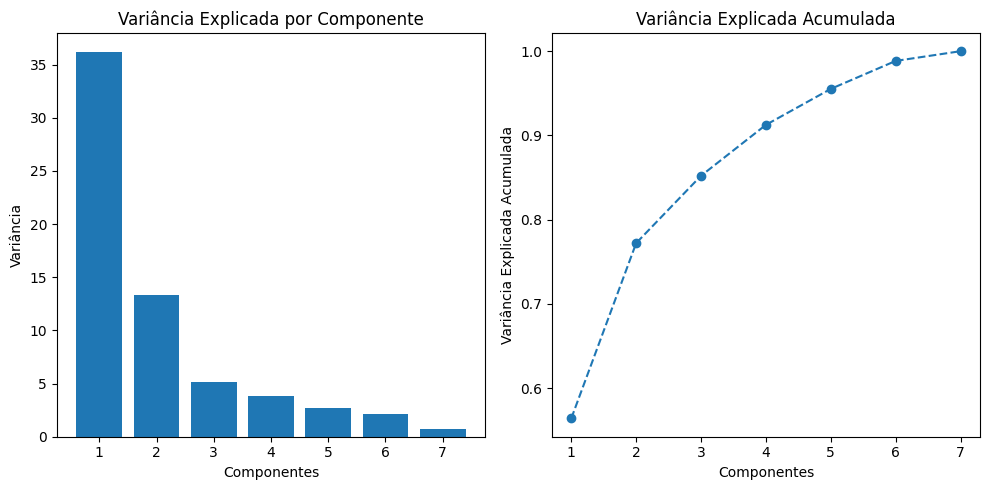

MSE da minha implementação: 5.481338482944996e-10
MSE da implementação do scikit-learn: 0.08308317608473972


In [7]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import KernelPCA as SklearnKernelPCA

# Exemplo de uso e comparação
# Carregando o conjunto de dados Iris
iris = load_iris()
X = iris.data

# Padronizando os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Parametros da função Kernel PCA
gamma = 0.1
variance_ratio_threshold = 0.95
kernel_type = 'rbf'
degree = 3
n_clusters = 5

# Minha implementação de Kernel PCA
kpca = KernelPCA(gamma, variance_ratio_threshold, kernel_type, degree, n_clusters)
X_pc = kpca.fit_transform(X_scaled)
X_reconstructed = kpca.inverse_transform(X_pc)

# Obtendo a variância explicada e os componentes
explained_variance = kpca.get_explained_variance()
explained_variance_ratio = kpca.get_explained_variance_ratio()
components = kpca.get_components()

print("Variância explicada:", explained_variance)
print("Razão da variância explicada:", explained_variance_ratio)
print("Componentes principais:\n", components)

# Plotando a variância explicada e a variância explicada acumulada
plt.figure(figsize=(10, 5))

# Plot da variância explicada
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Componentes')
plt.ylabel('Variância')
plt.title('Variância Explicada por Componente')

# Plot da variância explicada acumulada
plt.subplot(1, 2, 2)
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada')

plt.tight_layout()
plt.show()

# Implementação do scikit-learn
sklearn_kpca = SklearnKernelPCA(n_components=X_pc.shape[1], kernel='rbf', gamma=gamma, fit_inverse_transform=True)
X_pc_sklearn = sklearn_kpca.fit_transform(X_scaled)
X_reconstructed_sklearn = sklearn_kpca.inverse_transform(X_pc_sklearn)

# Comparação dos resultados
mse_my_implementation = mean_squared_error(X_scaled, X_reconstructed)
mse_sklearn_implementation = mean_squared_error(X_scaled, X_reconstructed_sklearn)

print("MSE da minha implementação:", mse_my_implementation)
print("MSE da implementação do scikit-learn:", mse_sklearn_implementation)
